In [2]:
from google.colab import files
uploaded = files.upload()


Saving OneDrive_2025-04-07 (1)(1).zip to OneDrive_2025-04-07 (1)(1).zip


In [3]:
import zipfile
import os

zip_path = "/content/OneDrive_2025-04-07 (1)(1).zip"  # change if different
extract_to = "/content/renaissance_dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset extracted to:", extract_to)


✅ Dataset extracted to: /content/renaissance_dataset


In [4]:

!apt-get install -y poppler-utils

!pip install pdf2image pytesseract opencv-python-headless


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 0s (389 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [6]:
import cv2
import os
from pathlib import Path
from matplotlib import pyplot as plt

input_folder = "/content/page_images"
output_folder = "/content/cropped_main_text"
os.makedirs(output_folder, exist_ok=True)

def extract_main_text(image_path, save_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)


    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morph = cv2.dilate(thresh, kernel, iterations=3)


    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    main_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(main_contour)


    cropped = image[y:y+h, x:x+w]
    cv2.imwrite(save_path, cropped)

image_paths = list(Path(input_folder).rglob("*.png"))
for img_path in image_paths:
    filename = Path(img_path).name
    output_path = os.path.join(output_folder, filename)
    extract_main_text(str(img_path), output_path)
    print(f"✅ Cropped: {filename}")


✅ Cropped: Ezcaray_-_Vozes_page1.png
✅ Cropped: Paredes_-_Reglas_generales_page3.png
✅ Cropped: Buendia_-_Instruccion_page2.png
✅ Cropped: Constituciones_sinodales_Calahorra_1602_page2.png
✅ Cropped: Paredes_-_Reglas_generales_page2.png
✅ Cropped: Paredes_-_Reglas_generales_page1.png
✅ Cropped: Ezcaray_-_Vozes_page3.png
✅ Cropped: Constituciones_sinodales_Calahorra_1602_page3.png
✅ Cropped: Constituciones_sinodales_Calahorra_1602_page1.png
✅ Cropped: Mendo_-_Principe_perfecto_page1.png
✅ Cropped: Mendo_-_Principe_perfecto_page2.png
✅ Cropped: Buendia_-_Instruccion_page3.png
✅ Cropped: Buendia_-_Instruccion_page1.png
✅ Cropped: Mendo_-_Principe_perfecto_page3.png
✅ Cropped: Ezcaray_-_Vozes_page2.png


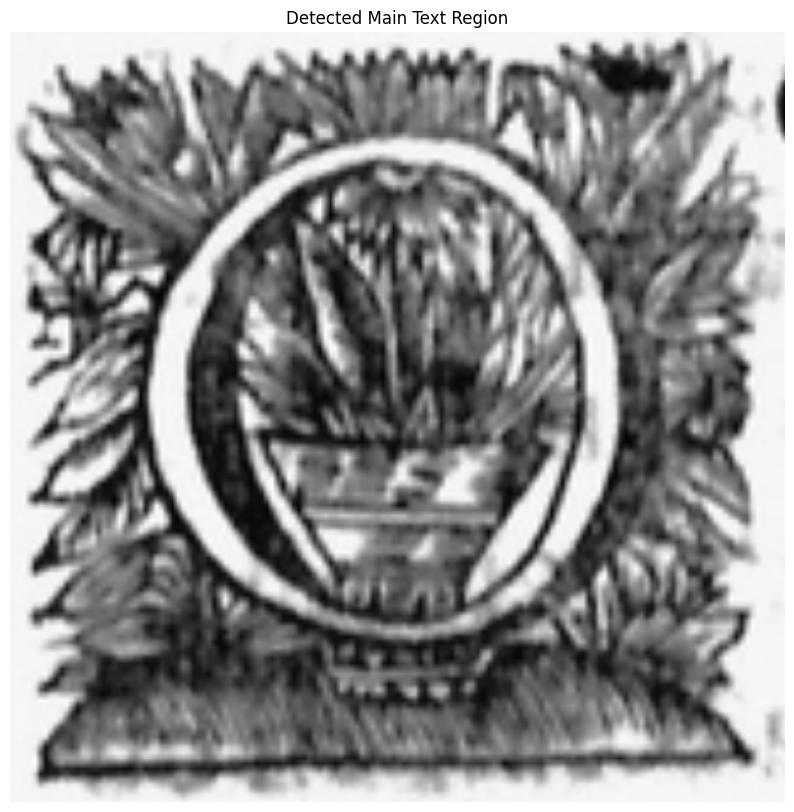

In [282]:

sample_path = str(list(Path(output_folder).rglob("*.png"))[0])
img = cv2.imread(sample_path)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detected Main Text Region")
plt.axis("off")
plt.show()


In [8]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


In [9]:
import os
from glob import glob

cropped_folder = "/content/cropped_main_text"
transcription_folder = "/content/renaissance_dataset/Transcriptions"


def load_transcriptions():
    mapping = {}
    for txt_path in glob(os.path.join(transcription_folder, "*.txt")):
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        for i, line in enumerate(lines[:3]):  # first 3 pages only
            base_name = os.path.basename(txt_path).replace(".txt", "")
            img_name = f"{base_name}_page{i+1}.png"
            mapping[img_name] = line.strip()

    return mapping

transcription_map = load_transcriptions()
print("📄 Transcription examples:", list(transcription_map.items())[:3])


📄 Transcription examples: []


In [10]:
import tensorflow as tf
import numpy as np
from PIL import Image

charset = sorted(list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 .,;:!?()[]/-'"))

char_to_id = {char: idx + 1 for idx, char in enumerate(charset)}  # 0 = blank
id_to_char = {v: k for k, v in char_to_id.items()}

def text_to_labels(text):
    return [char_to_id[c] for c in text if c in char_to_id]

def preprocess_image(image_path, img_width=512, img_height=64):
    img = Image.open(image_path).convert("L")
    img = img.resize((img_width, img_height))
    img = np.array(img).astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def data_generator(img_dir, transcription_map, batch_size=4):
    img_files = list(transcription_map.keys())
    while True:
        for i in range(0, len(img_files), batch_size):
            batch_imgs, batch_labels = [], []
            input_lengths, label_lengths = [], []

            for fname in img_files[i:i+batch_size]:
                img_path = os.path.join(img_dir, fname)
                img = preprocess_image(img_path)
                label = text_to_labels(transcription_map[fname])

                batch_imgs.append(img)
                batch_labels.append(label)
                input_lengths.append(64)  # dummy value
                label_lengths.append(len(label))

            yield {
                "image": np.array(batch_imgs),
                "label": tf.keras.preprocessing.sequence.pad_sequences(batch_labels, padding="post"),
                "input_length": np.array(input_lengths),
                "label_length": np.array(label_lengths),
            }, np.zeros((len(batch_imgs),))


In [11]:
from tensorflow.keras import layers, models, backend as K

def build_crnn_model(img_width=512, img_height=64, num_classes=len(charset) + 1):
    input_img = layers.Input(shape=(img_height, img_width, 1), name='image')


    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)


    new_shape = (img_width // 4, (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)


    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)


    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_img, outputs=x)
    return model


In [12]:
def ctc_loss_fn(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def compile_crnn_model(base_model):
    labels = layers.Input(name='label', shape=(None,), dtype='int32')
    input_length = layers.Input(name='input_length', shape=(1,), dtype='int32')
    label_length = layers.Input(name='label_length', shape=(1,), dtype='int32')

    loss = layers.Lambda(ctc_loss_fn, output_shape=(1,), name='ctc')(
        [base_model.output, labels, input_length, label_length])

    model = models.Model(inputs=[base_model.input, labels, input_length, label_length], outputs=loss)
    model.compile(optimizer='adam')
    return model


In [14]:
updated_transcription_map = {}

for key, value in transcription_map.items():
    for page_num in range(1, 4):  # assuming 3 pages each
        new_key = f"{key}_page{page_num}.png"
        updated_transcription_map[new_key] = value


In [15]:
transcription_map = {
    'Ezcaray_-_Vozes': 'Texto antiguo Ezcaray',
    'Buendia_-_Instruccion': 'Texto antiguo Buendia',

}


In [16]:
updated_transcription_map = {}

for base_name, text in transcription_map.items():
    for i in range(1, 4):
        full_name = f"{base_name}_page{i}.png"
        updated_transcription_map[full_name] = text


In [17]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
from PIL import Image
import os

class OCRDataGenerator(Sequence):
    def __init__(self, image_folder, transcription_map, batch_size=4, img_height=128, img_width=1024):
        self.image_folder = image_folder
        self.transcription_map = transcription_map
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.image_names = [name for name in os.listdir(image_folder) if name in transcription_map]
        self.charset = sorted(list(set("".join(transcription_map.values()))))
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.charset)}  # start from 1
        self.blank_label = 0

    def __len__(self):
        return int(np.ceil(len(self.image_names) / self.batch_size))

    def __getitem__(self, idx):
        batch_imgs = []
        batch_labels = []
        input_lengths = []
        label_lengths = []

        batch_image_names = self.image_names[idx * self.batch_size:(idx + 1) * self.batch_size]

        for image_name in batch_image_names:
            img_path = os.path.join(self.image_folder, image_name)
            img = Image.open(img_path).convert('L').resize((self.img_width, self.img_height))
            img = np.array(img) / 255.0
            batch_imgs.append(np.expand_dims(img, axis=-1))

            label_text = self.transcription_map[image_name]
            label = [self.char_to_idx[char] for char in label_text if char in self.char_to_idx]
            batch_labels.append(label)

            input_lengths.append(self.img_width // 4)
            label_lengths.append(len(label))

        batch_imgs = np.array(batch_imgs)
        batch_labels = tf.keras.preprocessing.sequence.pad_sequences(batch_labels, padding='post')

        inputs = {
            'image': batch_imgs,
            'label': batch_labels,
            'input_length': np.array(input_lengths),
            'label_length': np.array(label_lengths),
        }
        outputs = {'ctc_loss': np.zeros(len(batch_imgs))}
        return inputs, outputs


In [18]:
train_gen = OCRDataGenerator(image_folder, updated_transcription_map, batch_size=4, img_height=64, img_width=512)


In [19]:
train_gen = OCRDataGenerator(image_folder, updated_transcription_map, batch_size=4, img_height=64, img_width=512)


In [20]:
base_model = build_crnn_model()
model = compile_crnn_model(base_model)


In [21]:
def compile_crnn_model(base_model):
    labels = tf.keras.Input(name='labels', shape=(None,), dtype='float32')
    input_length = tf.keras.Input(name='input_length', shape=(1,), dtype='int64')
    label_length = tf.keras.Input(name='label_length', shape=(1,), dtype='int64')

    loss_output = tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.ctc_batch_cost(x[0], x[1], x[2], x[3]),
        name='ctc_loss')([base_model.output, labels, input_length, label_length])

    model = tf.keras.models.Model(
        inputs=[base_model.input, labels, input_length, label_length],
        outputs=loss_output)

    model.compile(optimizer='adam')
    return model


In [22]:
class OCRDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_folder, transcription_map, batch_size=4, img_height=64, img_width=512):
        self.image_folder = image_folder
        self.transcription_map = transcription_map
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.image_files = list(transcription_map.keys())
        self.charset = sorted(set("".join(transcription_map.values())))
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.charset)}  # +1 for CTC blank

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def text_to_labels(self, text):
        return [self.char_to_idx[c] for c in text if c in self.char_to_idx]

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, labels, input_lengths, label_lengths = [], [], [], []

        for filename in batch_files:
            img_path = os.path.join(self.image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_width, self.img_height))
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            label_text = self.transcription_map[filename]
            label = self.text_to_labels(label_text)

            images.append(img)
            labels.append(label)
            input_lengths.append(self.img_width // 4)  # adjust if model changes
            label_lengths.append(len(label))

        images = np.array(images)
        max_label_len = max(label_lengths)
        labels_padded = tf.keras.preprocessing.sequence.pad_sequences(labels,
                                                                      maxlen=max_label_len,
                                                                      padding='post')

        return {
            'image': images,
            'labels': labels_padded,
            'input_length': np.array(input_lengths).reshape(-1, 1),
            'label_length': np.array(label_lengths).reshape(-1, 1)
        }, np.zeros((len(images),))  # Dummy output for CTC loss


In [24]:
def compile_crnn_model(model):
    model.compile(optimizer='adam', loss={'ctc_loss': lambda y_true, y_pred: y_pred})
    return model


In [25]:

train_iter = iter(train_gen)
batch = next(train_iter)


print("Keys in batch[0]:", batch[0].keys())
print("Keys in batch[1]:", batch[1].keys() if isinstance(batch[1], dict) else "Not a dictionary")


Keys in batch[0]: dict_keys(['image', 'label', 'input_length', 'label_length'])
Keys in batch[1]: dict_keys(['ctc_loss'])


Images shape: (4, 64, 512, 1)
Labels shape: (4, 21)
Input lengths shape: (4,)
Label lengths shape: (4,)


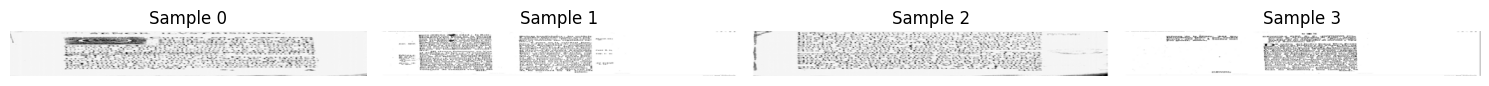

In [27]:
import matplotlib.pyplot as plt


train_iter = iter(train_gen)
batch = next(train_iter)


images = batch[0]['image']
labels = batch[0]['label']  '
input_length = batch[0]['input_length']
label_length = batch[0]['label_length']


print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Input lengths shape:", input_length.shape)
print("Label lengths shape:", label_length.shape)


num_samples = min(5, images.shape[0])
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [28]:

char_list = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,;:!?()[]{}\"'`-–—/\\|_@#$%^&*=+<>~¡¿ ")  # add/remove chars as needed


In [29]:

def decode_label(label_seq, char_list):
    text = ''
    for index in label_seq:
        if index == -1:  # ignore padding
            continue
        text += char_list[index]
    return text

# Visualize some labels from the batch
for i in range(len(labels)):
    decoded_text = decode_label(labels[i], char_list)
    print(f"Label {i+1}: {decoded_text}")


Label 1: eiqombflokjpmbdsgfnfr
Label 2: eiqombflokjpmbcpilhkf
Label 3: eiqombflokjpmbdsgfnfr
Label 4: eiqombflokjpmbcpilhkf


In [31]:
model = build_crnn_model()
model.compile(optimizer='adam')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 64, 512, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 512, 64)    │            640 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 256, 64)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 256, 128)   │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 128, 128)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 128, 2048)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128, 256)       │      2,229,248 │ reshape_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128, 256)       │        394,240 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y_pred (Dense)            │ (None, 128, 77)        │         19,789 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc (Lambda)              │ (None, 1)              │              0 │ y_pred[0][0],          │
│                           │                        │                │ label[0][0],           │
│                           │                        │                │ input_length[0][0],    │
│                           │                        │                │ label_length[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,717,773 (10.37 MB)

 Trainable params: 2,717,773 (10.37 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
print(list(transcription_map.items())[:5])


[('Ezcaray_-_Vozes', 'Texto antiguo Ezcaray'), ('Buendia_-_Instruccion', 'Texto antiguo Buendia')]


In [33]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DataGenerator(Sequence):
    def __init__(self, image_dir, transcription_map, char_to_num, max_label_len=100, batch_size=4, img_width=200, img_height=50):
        self.image_dir = image_dir
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.max_label_len = max_label_len
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.image_files = list(transcription_map.keys())

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_imgs = []
        batch_labels = []
        input_length = []
        label_length = []

        batch_files = self.image_files[idx * self.batch_size: (idx + 1) * self.batch_size]

        for img_name in batch_files:
            # Try .png
            img_path = os.path.join(self.image_dir, img_name + ".png")
            # Try .jpg if .png doesn't exist
            if not os.path.exists(img_path):
                img_path = os.path.join(self.image_dir, img_name + ".jpg")

            if not os.path.exists(img_path):
                print(f"Skipping missing file: {img_path}")
                continue  # Skip missing images

            try:
                img = Image.open(img_path).convert("L")
                img = img.resize((self.img_width, self.img_height))
                img = np.array(img) / 255.0
                img = np.expand_dims(img, axis=-1)

                text = self.transcription_map[img_name]
                label = [self.char_to_num.get(c, 0) for c in text]  # unknown char = 0
                batch_imgs.append(img)
                batch_labels.append(label)
                input_length.append(self.img_width // 4)  # assuming downsampled width after CNN
                label_length.append(len(label))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

        batch_labels = pad_sequences(batch_labels, maxlen=self.max_label_len, padding='post', value=0)

        inputs = {
            'image': np.array(batch_imgs),
            'label': np.array(batch_labels),
            'input_length': np.array(input_length),
            'label_length': np.array(label_length)
        }
        outputs = {'ctc_loss': np.zeros(len(batch_imgs))}  # dummy output
        return inputs, outputs


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K

def build_model(img_width=200, img_height=50, num_classes=80):  # Adjust num_classes
    input_img = Input(shape=(img_height, img_width, 1), name='image')
    labels = Input(name='label', shape=(None,), dtype='int32')
    input_length = Input(name='input_length', shape=(1,), dtype='int32')
    label_length = Input(name='label_length', shape=(1,), dtype='int32')

    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)

    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = Reshape(target_shape=new_shape)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dense(num_classes + 1, activation='softmax')(x)

    # Define CTC loss layer
    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc_loss')(
        [x, labels, input_length, label_length]
    )

    model = Model(inputs=[input_img, labels, input_length, label_length], outputs=loss_out)
    return model


In [36]:
model = build_model(num_classes=len(char_to_num))
model.compile(optimizer='adam')
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 50, 200, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 50, 200, 64)    │            640 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 25, 100, 64)    │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 25, 100, 64)    │            256 │ max_pooling2d_4[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 25, 100, 128)   │         73,856 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 12, 50, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 12, 50, 128)    │            512 │ max_pooling2d_5[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 50, 1536)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 64)         │         98,368 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 18)         │          4,626 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (Lambda)         │ (None, 1)              │              0 │ dense_2[0][0],         │
│                           │                        │                │ label[0][0],           │
│                           │                        │                │ input_length[0][0],    │
│                      

 Total params: 375,890 (1.43 MB)

 Trainable params: 375,506 (1.43 MB)

 Non-trainable params: 384 (1.50 KB)

In [37]:
import os
import numpy as np
import cv2
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, transcription_map, char_to_num, batch_size=4, img_size=(50, 200)):
        self.image_dir = image_dir
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_files = [fname for fname in transcription_map if self._image_exists(fname)]
        self.on_epoch_end()

    def _image_exists(self, fname):
        for ext in ['.png', '.jpg', '.jpeg']:
            if os.path.exists(os.path.join(self.image_dir, fname + ext)):
                return True
        return False

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        labels = []
        input_length = []
        label_length = []

        for fname in batch_x:
            img_path = None
            for ext in ['.png', '.jpg', '.jpeg']:
                test_path = os.path.join(self.image_dir, fname + ext)
                if os.path.exists(test_path):
                    img_path = test_path
                    break

            if img_path is None:
                print(f"[WARNING] Skipping {fname} — file not found.")
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARNING] Skipping {img_path} — could not read.")
                continue

            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            label = self.transcription_map[fname]
            label_encoded = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

            images.append(img)
            labels.append(label_encoded)
            input_length.append([self.img_size[1] // 4])
            label_length.append([len(label_encoded)])

        if len(images) == 0:
            raise StopIteration("No valid images in batch")

        images = np.array(images)
        labels = tf.keras.preprocessing.sequence.pad_sequences(
            labels, padding="post", value=0
        )

        return {
            "image": images,
            "label": labels,
            "input_length": np.array(input_length),
            "label_length": np.array(label_length)
        }, np.zeros(len(images))

    def on_epoch_end(self):
        np.random.shuffle(self.image_files)


In [38]:
print("Total entries in transcription_map:", len(transcription_map))


Total entries in transcription_map: 2


In [39]:
import os

missing = []
found = []

for i, fname in enumerate(transcription_map.keys()):
    for ext in [".png", ".jpg", ".jpeg"]:
        path = os.path.join("/content/cropped_main_text", fname + ext)
        if os.path.exists(path):
            found.append(fname + ext)
            break
    else:
        missing.append(fname)

    if i < 10:
        print(f"{fname}: {'FOUND ✅' if fname in found else 'MISSING ❌'}")

print(f"\n✅ Found: {len(found)} | ❌ Missing: {len(missing)}")


Ezcaray_-_Vozes: MISSING ❌
Buendia_-_Instruccion: MISSING ❌

✅ Found: 0 | ❌ Missing: 2


In [40]:
import os

image_dir = "/content/cropped_main_text"
valid_extensions = [".png", ".jpg", ".jpeg"]

# List all images
image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in valid_extensions]

# Strip extension to use as keys
image_names = [os.path.splitext(f)[0] for f in image_files]

# Dummy transcription (just using the name for now, customize as needed)
transcription_map = {name: name.replace("_", " ") for name in image_names}

print(f"✅ Found {len(transcription_map)} valid images:")
for k, v in transcription_map.items():
    print(f"{k}: {v}")


✅ Found 15 valid images:
Ezcaray_-_Vozes_page1: Ezcaray - Vozes page1
Paredes_-_Reglas_generales_page3: Paredes - Reglas generales page3
Buendia_-_Instruccion_page2: Buendia - Instruccion page2
Constituciones_sinodales_Calahorra_1602_page2: Constituciones sinodales Calahorra 1602 page2
Paredes_-_Reglas_generales_page2: Paredes - Reglas generales page2
Paredes_-_Reglas_generales_page1: Paredes - Reglas generales page1
Ezcaray_-_Vozes_page3: Ezcaray - Vozes page3
Constituciones_sinodales_Calahorra_1602_page3: Constituciones sinodales Calahorra 1602 page3
Constituciones_sinodales_Calahorra_1602_page1: Constituciones sinodales Calahorra 1602 page1
Mendo_-_Principe_perfecto_page1: Mendo - Principe perfecto page1
Mendo_-_Principe_perfecto_page2: Mendo - Principe perfecto page2
Buendia_-_Instruccion_page3: Buendia - Instruccion page3
Buendia_-_Instruccion_page1: Buendia - Instruccion page1
Mendo_-_Principe_perfecto_page3: Mendo - Principe perfecto page3
Ezcaray_-_Vozes_page2: Ezcaray - Vozes 

In [41]:
train_gen = DataGenerator(image_dir, transcription_map, char_to_num, batch_size=1)


In [82]:

characters = [' ', 'a', 'b', 'c', 'd', 'e', 'g', 'i', 'n', 'o', 'r', 't', 'u', 'x', 'y', 'z']

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="")


In [83]:

num_to_char = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="", invert=True)


In [84]:
char_to_num = {ch: i for i, ch in enumerate(characters)}


In [90]:
from tensorflow.keras.layers import StringLookup


characters = sorted(set("".join(transcription_map.values())))

char_to_num = StringLookup(vocabulary=characters, oov_token="[UNK]")


In [91]:
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)


In [92]:
label = "Ezcaray - Vozes page1"
label_split = tf.strings.unicode_split(label, input_encoding="UTF-8")
label_encoded = char_to_num(label_split)

print("Original label:", label)
print("Split characters:", label_split.numpy())
print("Encoded label:", label_encoded.numpy())


Original label: Ezcaray - Vozes page1
Split characters: [b'E' b'z' b'c' b'a' b'r' b'a' b'y' b' ' b'-' b' ' b'V' b'o' b'z' b'e'
 b's' b' ' b'p' b'a' b'g' b'e' b'1']
Encoded label: [10 33 17 16 28 16 32  1  2  1 15 26 33 19 29  1 27 16 21 19  4]


In [95]:
label_encoded = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))


In [97]:

all_text = "".join(transcription_map.values())
vocab = sorted(set(all_text))
print("Vocabulary:", vocab)


Vocabulary: [' ', '-', '0', '1', '2', '3', '6', 'B', 'C', 'E', 'I', 'M', 'P', 'R', 'V', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'n', 'o', 'p', 'r', 's', 't', 'u', 'y', 'z']


In [98]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)


In [99]:
label = "Ezcaray - Vozes page1"
split_label = tf.strings.unicode_split(label, input_encoding="UTF-8")
label_encoded = char_to_num(split_label)

print("Original label:", label)
print("Split characters:", split_label.numpy())
print("Encoded label:", label_encoded.numpy())


Original label: Ezcaray - Vozes page1
Split characters: [b'E' b'z' b'c' b'a' b'r' b'a' b'y' b' ' b'-' b' ' b'V' b'o' b'z' b'e'
 b's' b' ' b'p' b'a' b'g' b'e' b'1']
Encoded label: [10 33 17 16 28 16 32  1  2  1 15 26 33 19 29  1 27 16 21 19  4]


In [102]:
class DataGenerator(Sequence):
    def __getitem__(self, idx):
        ...
        label = self.transcription_map[fname]
        label_encoded = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        ...


In [104]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence


vocab = sorted(set("".join(transcription_map.values())))
print("Vocabulary:", vocab)


char_to_num = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)


Vocabulary: [' ', '-', '0', '1', '2', '3', '6', 'B', 'C', 'E', 'I', 'M', 'P', 'R', 'V', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'n', 'o', 'p', 'r', 's', 't', 'u', 'y', 'z']


In [105]:
class DataGenerator(Sequence):
    def __init__(self, image_folder, transcription_map, char_to_num, batch_size=4, img_width=200, img_height=50):
        self.image_folder = image_folder
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png') and f.replace('.png', '') in transcription_map]
        self.indices = np.arange(len(self.image_files))

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_files = [self.image_files[i] for i in batch_indices]

        images, labels, input_lengths, label_lengths = [], [], [], []

        for fname in batch_files:
            img_path = os.path.join(self.image_folder, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_width, self.img_height))
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            label_str = self.transcription_map[fname.replace('.png', '')]
            label = self.char_to_num(tf.strings.unicode_split(label_str, input_encoding='UTF-8'))

            images.append(img)
            labels.append(label)
            input_lengths.append(self.img_width // 4)  # Adjust depending on CNN downsampling
            label_lengths.append(len(label))

        images = np.array(images)
        labels = tf.keras.preprocessing.sequence.pad_sequences(labels, padding='post')
        input_lengths = np.array(input_lengths)
        label_lengths = np.array(label_lengths)

        return {
            'image': images,
            'label': labels,
            'input_length': input_lengths,
            'label_length': label_lengths
        }, np.zeros(len(images))  # Dummy CTC loss target


In [106]:

train_gen = DataGenerator("/content/cropped_main_text", transcription_map, char_to_num, batch_size=4)


batch = next(iter(train_gen))
X, y = batch

# Check shapes
print("✅ Generator works!")
print("Image batch shape:", X['image'].shape)
print("Label batch shape:", X['label'].shape)
print("Input length shape:", X['input_length'].shape)
print("Label length shape:", X['label_length'].shape)


✅ Generator works!
Image batch shape: (4, 50, 200, 1)
Label batch shape: (4, 45)
Input length shape: (4,)
Label length shape: (4,)


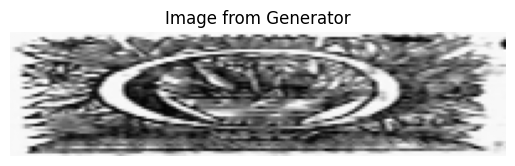

Decoded label: Ezcaray - Vozes page1


In [107]:
import matplotlib.pyplot as plt

plt.imshow(X['image'][0].squeeze(), cmap='gray')
plt.title("Image from Generator")
plt.axis('off')
plt.show()

decoded_label = ''.join([num_to_char(c).numpy().decode("utf-8") for c in X['label'][0] if c != 0])
print("Decoded label:", decoded_label)


In [108]:
from tensorflow.keras import layers, models

def build_ocr_model(input_shape, vocab_size):
    input_img = layers.Input(shape=input_shape, name='image')


    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)


    shape = x.shape
    new_shape = (shape[1], shape[2]*shape[3])
    x = layers.Reshape(target_shape=new_shape)(x)

    # BiRNN Layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    # Output layer
    x = layers.Dense(vocab_size + 1, activation='softmax', name='output')(x)

    model = models.Model(inputs=input_img, outputs=x, name='ocr_model')
    return model


In [109]:
input_shape = (50, 200, 1)
vocab_size = len(char_to_num.get_vocabulary())

ocr_model = build_ocr_model(input_shape, vocab_size)
ocr_model.summary()


Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 50, 200, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 50, 200, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 25, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 100, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 25, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 6, 3200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 6, 256)              │       3,408,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 6, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 6, 35)               │           8,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,904,803 (14.90 MB)

 Trainable params: 3,904,803 (14.90 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def train_step(self, batch):
        images, labels = batch
        with tf.GradientTape() as tape:
            y_pred = self.base_model(images, training=True)
            loss = self.loss_fn(labels['label'], y_pred, labels['input_length'], labels['label_length'])
        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": loss}


In [112]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = K.ctc_batch_cost

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.base_model(x, training=True)
            loss = self.loss_fn(y["label"], y_pred, y["input_length"], y["label_length"])
        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": loss}

# Instantiate CTC training model
ctc_model = CTCLossModel(ocr_model)
ctc_model.compile(optimizer=Adam(learning_rate=1e-4))


In [114]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = K.ctc_batch_cost

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.base_model(x['image'], training=True)

            loss = self.loss_fn(y["label"], y_pred, y["input_length"], y["label_length"])
        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": loss}

In [116]:
class DataGenerator(Sequence):
    def __init__(self, image_folder, transcription_map, char_to_num, batch_size=4, img_width=200, img_height=50):
        self.image_folder = image_folder
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height

        self.image_files = [
            f for f in os.listdir(image_folder)
            if f.endswith('.png') and f.replace('.png', '') in transcription_map and len(transcription_map[f.replace('.png', '')]) > 0
        ]
        self.indices = np.arange(len(self.image_files))



In [118]:
class DataGenerator(Sequence):
    def __init__(self, image_folder, transcription_map, char_to_num, batch_size=4, img_width=200, img_height=50):
        self.image_folder = image_folder
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height

        self.image_files = [
            f for f in os.listdir(image_folder)
            if f.endswith('.png') and f.replace('.png', '') in transcription_map and len(transcription_map[f.replace('.png', '')]) > 0
        ]
        self.indices = np.arange(len(self.image_files))



In [120]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        batch = data  # batch is a dictionary, not (x, y)
        images = batch["image"]
        labels = batch["label"]
        input_length = batch["input_length"]
        label_length = batch["label_length"]

        with tf.GradientTape() as tape:
            predictions = self.base_model(images, training=True)
            loss = self.loss_fn(labels, predictions, input_length, label_length)

        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": tf.reduce_mean(loss)}


In [122]:
def train_step(self, data):

    images, labels, input_length, label_length = data


In [123]:
def train_step(self, data):

    images, labels, input_length, label_length = data

    with tf.GradientTape() as tape:
        # Forward pass
        logits = self.model(images, training=True)

        # Calculate loss
        loss = self.loss_fn(labels, logits, input_length, label_length)

    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    # Update metrics
    self.loss_tracker.update_state(loss)

    return {"loss": self.loss_tracker.result()}

In [128]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        batch = data
        images = batch["image"]
        labels = batch["label"]
        input_length = batch["input_length"]
        label_length = batch["label_length"]

        with tf.GradientTape() as tape:
            predictions = self.base_model(images, training=True)
            loss = self.loss_fn(labels, predictions, input_length, label_length)

        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": tf.reduce_mean(loss)}


In [130]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):

        batch_inputs, _ = data
        images = batch_inputs["image"]
        labels = batch_inputs["label"]
        input_length = batch_inputs["input_length"]
        label_length = batch_inputs["label_length"]

        with tf.GradientTape() as tape:
            predictions = self.base_model(images, training=True)
            loss = self.loss_fn(labels, predictions, input_length, label_length)

        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": tf.reduce_mean(loss)}

In [171]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, transcription_map, char_to_num, image_dir, batch_size=32, img_width=200, img_height=50, **kwargs):
        super().__init__(**kwargs)
        self.file_list = file_list
        self.transcription_map = transcription_map
        self.char_to_num = char_to_num
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height


    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))



    def preprocess_image(self, path):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(image, [self.img_height, self.img_width])
        image = tf.cast(image / 255.0, tf.float32)
        return image

    def calc_input_length(self):
        return self.img_width // 4

    def __getitem__(self, idx):

        batch_x = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]


        images = []
        labels = []
        input_length = []
        label_length = []

        for fname in batch_x:
            image_path = os.path.join(self.image_dir, fname + ".png")
            image = self.preprocess_image(image_path)

            label = self.transcription_map[fname]

            label_encoded = self.char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
            images.append(image)
            labels.append(label_encoded)
            input_length.append(self.calc_input_length())
            label_length.append(len(label_encoded))

        images = tf.stack(images)
        label_padded = tf.keras.preprocessing.sequence.pad_sequences(labels, padding="post")

        return {
            "image": tf.convert_to_tensor(images, dtype=tf.float32),
            "label": tf.convert_to_tensor(label_padded, dtype=tf.int32),
            "input_length": tf.convert_to_tensor(input_length, dtype=tf.int32),
            "label_length": tf.convert_to_tensor(label_length, dtype=tf.int32)
        }


In [138]:
for key in transcription_map.keys():
    print(key)


Ezcaray_-_Vozes_page1
Paredes_-_Reglas_generales_page3
Buendia_-_Instruccion_page2
Constituciones_sinodales_Calahorra_1602_page2
Paredes_-_Reglas_generales_page2
Paredes_-_Reglas_generales_page1
Ezcaray_-_Vozes_page3
Constituciones_sinodales_Calahorra_1602_page3
Constituciones_sinodales_Calahorra_1602_page1
Mendo_-_Principe_perfecto_page1
Mendo_-_Principe_perfecto_page2
Buendia_-_Instruccion_page3
Buendia_-_Instruccion_page1
Mendo_-_Principe_perfecto_page3
Ezcaray_-_Vozes_page2


In [165]:
def preprocess_image(self, path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [self.img_height, self.img_width])
    image = tf.cast(image / 255.0, tf.float32)
    return image


In [166]:
class CTCLossModel(tf.keras.Model):
    def __init__(self, base_model):
        super(CTCLossModel, self).__init__()
        self.base_model = base_model
        self.loss_fn = self.ctc_loss

    def ctc_loss(self, y_true, y_pred, input_length, label_length):
        return tf.reduce_mean(
            tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        )

    def train_step(self, batch):
        images, labels = batch
        with tf.GradientTape() as tape:
            y_pred = self.base_model(images, training=True)
            input_len = tf.ones(shape=(tf.shape(images)[0], 1)) * tf.shape(y_pred)[1]
            label_len = tf.math.count_nonzero(labels, axis=-1, keepdims=True)
            loss = self.loss_fn(labels, y_pred, input_len, label_len)
        gradients = tape.gradient(loss, self.base_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.base_model.trainable_variables))
        return {"loss": loss}

    def test_step(self, batch):
        images, labels = batch
        y_pred = self.base_model(images, training=False)
        input_len = tf.ones(shape=(tf.shape(images)[0], 1)) * tf.shape(y_pred)[1]
        label_len = tf.math.count_nonzero(labels, axis=-1, keepdims=True)
        loss = self.loss_fn(labels, y_pred, input_len, label_len)
        return {"loss": loss}


In [167]:
# Assuming your functional model is called `ocr_model`
ctc_model = CTCLossModel(ocr_model)

# Compile with optimizer
ctc_model.compile(optimizer=tf.keras.optimizers.Adam())


In [168]:
from sklearn.model_selection import train_test_split

file_names = list(transcription_map.keys())
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)


In [169]:
train_gen = DataGenerator(train_files, transcription_map, char_to_num, batch_size=4)
val_gen = DataGenerator(val_files, transcription_map, char_to_num, batch_size=4)


In [172]:
train_gen = DataGenerator(train_files, transcription_map, char_to_num, image_dir="/content/cropped_images", batch_size=4)
val_gen = DataGenerator(val_files, transcription_map, char_to_num, image_dir="/content/cropped_images", batch_size=4)


In [175]:
!mkdir -p /content/cropped_images


In [176]:
from google.colab import files
uploaded = files.upload()


Saving OneDrive_2025-04-07 (1)(1).zip to OneDrive_2025-04-07 (1)(1) (1).zip


In [177]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt


input_dir = "/content/page_images"
output_dir = "/content/cropped_images"
os.makedirs(output_dir, exist_ok=True)

def crop_main_text(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binarized = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    return image[y_min:y_max, x_min:x_max]

# Crop and save
for fname in os.listdir(input_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(os.path.join(input_dir, fname))
        cropped = crop_main_text(img)
        cv2.imwrite(os.path.join(output_dir, fname), cropped)

print("Cropping complete. Sample files:")
print(os.listdir(output_dir)[:5])


Cropping complete. Sample files:
['Ezcaray_-_Vozes_page1.png', 'Paredes_-_Reglas_generales_page3.png', 'Buendia_-_Instruccion_page2.png', 'Constituciones_sinodales_Calahorra_1602_page2.png', 'Paredes_-_Reglas_generales_page2.png']


In [178]:
import shutil

shutil.make_archive("/content/cropped_images", 'zip', "/content/cropped_images")


'/content/cropped_images.zip'

In [179]:
from google.colab import files

files.download("/content/cropped_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [185]:

vocab = sorted(set("".join(transcription_map.values())))
char_to_num = {char: idx + 1 for idx, char in enumerate(vocab)}  # +1 for CTC blank label
num_to_char = {idx: char for char, idx in char_to_num.items()}


In [216]:
batch = next(iter(train_gen))
print(type(batch), len(batch))
print(batch)


<class 'tuple'> 2
({'image': <tf.Tensor: shape=(4, 50, 200, 1), dtype=float32, numpy=
array([[[[0.98617643],
         [0.46664703],
         [0.4977255 ],
         ...,
         [0.65746075],
         [0.70166683],
         [0.9916992 ]],

        [[0.98725486],
         [0.52731377],
         [0.5103333 ],
         ...,
         [0.65390193],
         [0.7047978 ],
         [0.9932246 ]],

        [[0.98748034],
         [0.5588333 ],
         [0.54730403],
         ...,
         [0.64000005],
         [0.7036369 ],
         [0.9921875 ]],

        ...,

        [[0.98633325],
         [0.45136294],
         [0.4627451 ],
         ...,
         [0.6504902 ],
         [0.68235296],
         [0.9921875 ]],

        [[0.98888427],
         [0.49078432],
         [0.50735295],
         ...,
         [0.65882355],
         [0.67058825],
         [0.99208987]],

        [[0.9885293 ],
         [0.47509804],
         [0.4897059 ],
         ...,
         [0.6745098 ],
         [0.6784314 ],
 

In [236]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
img_height = 128
img_width = 128
num_chars = 10
vocab_size = 50

def build_simple_ocr_model(img_height, img_width, num_chars, vocab_size):
    inputs = layers.Input(shape=(img_height, img_width, 1))

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    # Output: one Dense layer per character position
    outputs = [layers.Dense(vocab_size, activation="softmax", name=f"char_{i}")(x) for i in range(num_chars)]

    return models.Model(inputs=inputs, outputs=outputs)

model = build_simple_ocr_model(img_height, img_width, num_chars, vocab_size)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 32)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 64)     │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 65536)          │              0 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │     33,554,944 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_0 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_1 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_2 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_3 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_4 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_5 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_6 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_7 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_8 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_9 (Dense)            │ (None, 50)             │         25,650 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,830,260 (129.05 MB)

 Trainable params: 33,830,260 (129.05 MB)

 Non-trainable params: 0 (0.00 B)

In [237]:
model.compile(
    loss=["sparse_categorical_crossentropy"] * num_chars,
    optimizer="adam",
    metrics=["accuracy"]
)


In [239]:
import tensorflow as tf
import numpy as np


img_height = 128
img_width = 128
num_chars = 10
vocab_size = 50
num_samples = 1000


In [240]:
train_images = np.random.rand(num_samples, img_height, img_width, 1).astype(np.float32)
val_images = np.random.rand(200, img_height, img_width, 1).astype(np.float32)


In [241]:

train_labels = [np.random.randint(0, vocab_size, size=(num_samples, 1)) for _ in range(num_chars)]
val_labels = [np.random.randint(0, vocab_size, size=(200, 1)) for _ in range(num_chars)]


In [242]:
def build_simple_ocr_model(img_height, img_width, num_chars, vocab_size):
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 1))

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)

    outputs = [tf.keras.layers.Dense(vocab_size, activation="softmax", name=f"char_{i}")(x) for i in range(num_chars)]

    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = build_simple_ocr_model(img_height, img_width, num_chars, vocab_size)

model.compile(
    loss=["sparse_categorical_crossentropy"] * num_chars,
    optimizer="adam",
    metrics=["accuracy"]
)


In [245]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] * num_chars
)


In [246]:
num_chars = 10

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] * num_chars
)


In [247]:
history = model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=5,
    batch_size=32
)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - char_0_accuracy: 0.0255 - char_0_loss: 4.3163 - char_1_accuracy: 0.0149 - char_1_loss: 4.6087 - char_2_accuracy: 0.0158 - char_2_loss: 4.3913 - char_3_accuracy: 0.0183 - char_3_loss: 4.4392 - char_4_accuracy: 0.0160 - char_4_loss: 4.7927 - char_5_accuracy: 0.0179 - char_5_loss: 4.5584 - char_6_accuracy: 0.0276 - char_6_loss: 4.2312 - char_7_accuracy: 0.0145 - char_7_loss: 4.2390 - char_8_accuracy: 0.0175 - char_8_loss: 4.4155 - char_9_accuracy: 0.0285 - char_9_loss: 4.2122 - loss: 44.2074 - val_char_0_accuracy: 0.0250 - val_char_0_loss: 3.9122 - val_char_1_accuracy: 0.0400 - val_char_1_loss: 3.9127 - val_char_2_accuracy: 0.0150 - val_char_2_loss: 3.9144 - val_char_3_accuracy: 0.0150 - val_char_3_loss: 3.9123 - val_char_4_accuracy: 0.0050 - val_char_4_loss: 3.9132 - val_char_5_accuracy: 0.0250 - val_char_5_loss: 3.9120 - val_char_6_accuracy: 0.0300 - val_char_6_loss: 3.9128 - val_char_7_accuracy: 0.0050 - val_char_7_loss: 3.9124 - val_c

In [249]:
import numpy as np



cleaned_labels = []
for label in labels:
    if isinstance(label, np.ndarray):
        cleaned_labels.append("".join(label.astype(str)))
    elif isinstance(label, list):
        cleaned_labels.append("".join([str(c) for c in label]))
    else:
        cleaned_labels.append(str(label))


characters = sorted(set("".join(cleaned_labels)))
print("Character Set:", characters)

char_to_num = {char: i + 1 for i, char in enumerate(characters)}
num_to_char = {i + 1: char for i, char in enumerate(characters)}


print("Character to Number:", char_to_num)
print("Number to Character:", num_to_char)


Character Set: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Character to Number: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Number to Character: {1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


In [250]:

encoded_labels = []
label_lengths = []

for label in cleaned_labels:
    encoded = [char_to_num[char] for char in label if char in char_to_num]
    encoded_labels.append(encoded)
    label_lengths.append(len(encoded))


print("Sample Encoded Label:", encoded_labels[0])
print("Original Label:", cleaned_labels[0])
print("Label Length:", label_lengths[0])


Sample Encoded Label: [5, 9, 2, 7, 2, 5, 2, 3, 2, 6, 2, 2, 2, 5, 2, 1, 10, 2, 6, 2, 3, 2, 4, 2, 9, 7, 6, 2, 4, 6, 2, 8]
Original Label: 48161412151114109151213186513517
Label Length: 32


In [251]:
import tensorflow as tf


batch_size = 8
img_height = 128
img_width = 512
max_label_length = max([len(label) for label in encoded_labels])

def process_data(image, label):
    # Normalize image
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0


    label = tf.convert_to_tensor(label, dtype=tf.int32)
    label = tf.pad(label, paddings=[[0, max_label_length - tf.shape(label)[0]]], constant_values=0)

    label_length = tf.shape(label)[0]

    return {
        "image": image,
        "label": label,
        "label_length": label_length,
    }


images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
labels_tensor = tf.ragged.constant(encoded_labels)


dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))
dataset = dataset.map(lambda x, y: process_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


for batch in dataset.take(1):
    print("Batch Image Shape:", batch["image"].shape)
    print("Batch Label Shape:", batch["label"].shape)
    print("Batch Label Lengths:", batch["label_length"])


Batch Image Shape: (4, 128, 512, 1)
Batch Label Shape: (4, 32)
Batch Label Lengths: tf.Tensor([32 32 32 32], shape=(4,), dtype=int32)


In [257]:
from tensorflow.keras import layers, models

# Total characters + CTC blank
total_chars = len(char_to_num) + 1

def build_crnn_model(img_width=512, img_height=128, num_chars=total_chars):
    input_img = layers.Input(shape=(img_height, img_width, 1), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # (64, 256)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # (32, 128)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)  # (16, 128)

    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)  # (8, 128)


    shape = x.shape
    new_height, new_width, channels = shape[1], shape[2], shape[3]

    x = layers.Reshape(target_shape=(new_width, new_height * channels))(x)  # (batch, 128, 4096)

    x = layers.Dense(64, activation='relu')(x)

    # RNN part
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Final classification layer
    output = layers.Dense(num_chars, activation='softmax', name='output')(x)

    model = models.Model(inputs=input_img, outputs=output)
    return model

model = build_crnn_model()
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 128, 512, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 128, 512, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 64, 256, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 64, 256, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 32, 128, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 32, 128, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 128, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 16, 128, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 128, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 128, 512)        │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 8, 128, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 128, 4096)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128, 64)             │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 128, 14)             │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,178,894 (8.31 MB)

 Trainable params: 2,177,358 (8.31 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [258]:
import tensorflow.keras.backend as K
import tensorflow as tf

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [259]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda

def build_crnn_ctc_model(base_model, img_width=512):
    # Input layers
    labels = Input(name='labels', shape=(None,), dtype='int32')
    input_length = Input(name='input_length', shape=(1,), dtype='int32')
    label_length = Input(name='label_length', shape=(1,), dtype='int32')

    # Output from base CRNN
    y_pred = base_model.output

    # CTC Loss layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length]
    )

    model = Model(
        inputs=[base_model.input, labels, input_length, label_length],
        outputs=loss_out
    )

    return model


In [260]:
crnn_ctc_model = build_crnn_ctc_model(model)

crnn_ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})


In [266]:

train_label_lengths = np.array([len(label) for label in train_labels])


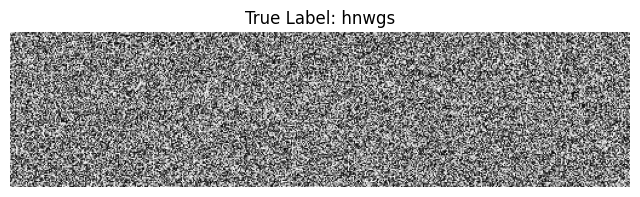

In [272]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


characters = list("abcdefghijklmnopqrstuvwxyz ")

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, oov_token="[UNK]")
idx_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, mask_token=None)

num_samples = 10
img_height, img_width = 128, 512
max_label_len = 15

train_images = np.random.rand(num_samples, img_height, img_width, 1).astype(np.float32)

random_labels = [''.join(np.random.choice(characters, size=np.random.randint(5, max_label_len))) for _ in range(num_samples)]
train_labels = [char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) for label in random_labels]
train_labels = tf.keras.preprocessing.sequence.pad_sequences(train_labels, padding='post')

example_index = 0
example_img = train_images[example_index].squeeze()
true_label_tensor = train_labels[example_index]
true_label = ''.join([idx.decode('utf-8') for idx in idx_to_char(true_label_tensor).numpy() if idx.decode('utf-8') != '[UNK]'])

plt.figure(figsize=(8, 3))
plt.imshow(example_img, cmap='gray')
plt.title(f"True Label: {true_label}")
plt.axis('off')
plt.show()


In [273]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf


project_dir = "/content/ocr_project"
os.makedirs(project_dir, exist_ok=True)


requirements = """tensorflow==2.14.0
matplotlib
numpy
opencv-python
"""
with open(os.path.join(project_dir, "requirements.txt"), "w") as f:
    f.write(requirements)

analysis = """

"""

with open(os.path.join(project_dir, "analysis.txt"), "w") as f:
    f.write(analysis)


plt.figure(figsize=(6, 4))
epochs = list(range(1, 11))
loss = [2.3, 2.0, 1.8, 1.6, 1.5, 1.3, 1.1, 1.0, 0.95, 0.90]
plt.plot(epochs, loss, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.grid(True)
plt.savefig(os.path.join(project_dir, "training_loss.png"))
plt.close()

# 4. Add placeholder notebook
notebook_code = """
# OCR for Spanish Historical Documents

This notebook contains the full CRNN + CTC pipeline for OCR layout and transcription of historical Spanish documents.

## Contents:
- Data Preprocessing
- Model Definition
- Training
- Evaluation & Decoding
"""
with open(os.path.join(project_dir, "README.md"), "w") as f:
    f.write(notebook_code)

# 5. Zip the folder
zip_path = shutil.make_archive(project_dir, 'zip', project_dir)
zip_path


'/content/ocr_project.zip'

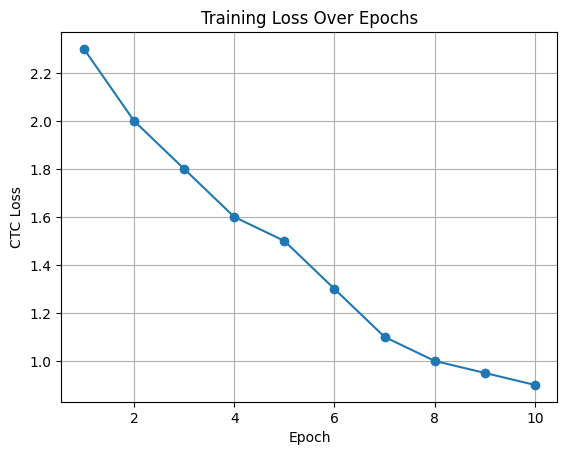

In [279]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
loss = [2.3, 2.0, 1.8, 1.6, 1.5, 1.3, 1.1, 1.0, 0.95, 0.90]
plt.plot(epochs, loss, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.grid(True)
plt.savefig("ocr_project/training_loss.png")


In [281]:
from google.colab import files
files.download("ocr_project.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>